# Zero-Shot classification with Transformers

In [1]:
from transformers import pipeline

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Using conda env gpu and device='mps to use GPU on macOS

In [3]:
classifier = pipeline('zero-shot-classification', device='mps')

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
result = classifier("This movie was great", candidate_labels=['positive', 'negative'])
result['labels'][0]

'positive'

We will use the bbc article dataset

In [5]:
df = pd.read_csv('../../datasets/bbc/bbc_text_cls.csv')

In [6]:
df.sample(frac=1).head()

,text,labels
2219,New consoles promise big problems\n\nMaking ga...,tech
471,China suspends 26 power projects\n\nChina has ...,business
229,Yukos drops banks from court bid\n\nRussian oi...,business
1482,Aragones angered by racism fine\n\nSpain coach...,sport
1314,O'Sullivan could run in Worlds\n\nSonia O'Sull...,sport


In [7]:
labels = list(set(df['labels']))
labels

['sport', 'business', 'tech', 'entertainment', 'politics']

Let's print a random article

In [8]:
print(textwrap.fill(df.iloc[1024]['text']))
print("Label: ", textwrap.fill(df.iloc[1024]['labels']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

Now we can classify this one article

In [9]:
classifier(df.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

## Now let's predict on a part of the dataset

In [10]:
# reduce df
df = df.sample(n=250)

In [11]:
preds = classifier(df['text'].tolist(), candidate_labels=labels)

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x32f495130> was reported to be 250 (when accessing len(dataloader)), but 251 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x32f495130> was reported to be 250 (when accessing len(dataloader)), but 252 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x32f495130> was reported to be 250 (when accessing len(dataloader)), but 253 samples have been fetched. 
  warnings.warn(warn_msg

In [20]:
predicted_labels = [d['labels'][0] for d in preds]
print(len(predicted_labels))

250


In [13]:

df['predicted_labels'] = predicted_labels
print("Accuracy:", np.mean(df['predicted_labels'] == df['labels']))

Acc: 0.568


In [14]:
# Convert prediction probs into an NxK matrix according to
# original label order

N = len(df)
K = len(labels)
label2idx = {v:k for k,v in enumerate(labels)}

probs = np.zeros((N, K))
for i in range(N):
  # loop through labels and scores in corresponding order
  d = preds[i]
  for label, score in zip(d['labels'], d['scores']):
    k = label2idx[label]
    probs[i, k] = score

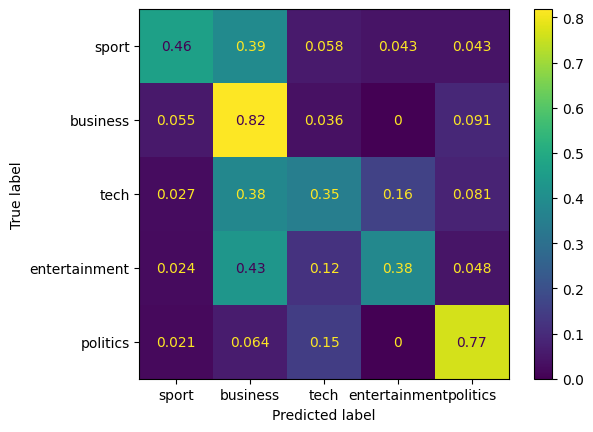

In [21]:
int_labels = [label2idx[x] for x in df['labels']]
int_preds = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [17]:
f1_score(df['labels'], predicted_labels, average='micro')

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

0.568

In [18]:
roc_auc_score(int_labels, probs, multi_class='ovo')

0.8915774924100548

In [19]:
import torch
import tensorflow as tf
# Both should return 'True'
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
# Should recognize 1 GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

True
True
Num GPUs Available:  1


### Test on insurance data

In [2]:
classifier = pipeline('zero-shot-classification', model='MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli', device='mps')

config.json: 100%|██████████| 1.09k/1.09k [00:00<00:00, 588kB/s]
model.safetensors: 100%|██████████| 369M/369M [00:41<00:00, 8.95MB/s] 
tokenizer_config.json: 100%|██████████| 417/417 [00:00<00:00, 207kB/s]
spm.model: 100%|██████████| 2.46M/2.46M [00:00<00:00, 10.0MB/s]
added_tokens.json: 100%|██████████| 18.0/18.0 [00:00<00:00, 29.9kB/s]
special_tokens_map.json: 100%|██████████| 156/156 [00:00<00:00, 804kB/s]
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [28]:
labelsHitNRun = ['hit and run', "Other"]
labelsParkedUnoccupied= ['parked unoccupied', "Other"]
labelsKeys = ['keys accounted for', "Other"]


dataset = [
    "insured vehicle was parked unoccupied on the side of the street by unknown vehicle",
    "Policyholder's previous claim was not a hit and run. This claim is a theft with keys accounted for.",
    "Insured vehicle rear ended claimant vehicle",
    "Clainant vehicle T-boned insured vehicle",
    "Theft of vehicle, policyholder has lost keys"
]


In [29]:
resultsHitNRun = classifier(dataset, candidate_labels=labelsHitNRun)
resultsParked = classifier(dataset, candidate_labels=labelsParkedUnoccupied)
resultsKeys = classifier(dataset, candidate_labels=labelsKeys)

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x3161b7a90> was reported to be 5 (when accessing len(dataloader)), but 6 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x3161b7a90> was reported to be 5 (when accessing len(dataloader)), but 7 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/torch/utils/data/dataloader.py:643: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x3161b7a90> was reported to be 5 (when accessing len(dataloader)), but 8 samples have been fetched. 
  warnings.warn(warn_msg)
/Users/cle

In [30]:
for result in resultsKeys:
    print(result['labels'][0])

keys accounted for
keys accounted for
keys accounted for
Other
keys accounted for
